# Script to check the baseline error raw THz streaking data at SwissFEL Alvra and save results as h5 file
- General documentation https://docs.google.com/document/d/1Ll3_WsHzFwuvL-sWgqWQUSYKJRgFG6W7PWY-NJ40WS0/edit?usp=sharing
- User guide ADD WEBSITE
- Comments to christopher.arrell@psi.ch

In [1]:
import photodiag
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import json
import os
from time import sleep
from IPython.display import clear_output, display
%matplotlib notebook

In [2]:
def LoadData(fn):
    with h5.File(fn, 'r') as f:
        try:
            TOF = -f['data/SAROP11-PALMK118:CH2_BUFFER/data'][:]
            uTOF = -f['data/SAROP11-PALMK118:CH1_BUFFER/data'][:]
            PulseIds = f['data/SAROP11-PALMK118:CH2_BUFFER/pulse_id'][:]
            Events = f['data/SAR-CVME-TIFALL5:EvtSet/data'][:]
        except:
            TOF = -f['SAROP11-PALMK118:CH2_BUFFER/data'][:]
            uTOF = -f['SAROP11-PALMK118:CH1_BUFFER/data'][:]
            PulseIds = f['SAROP11-PALMK118:CH2_BUFFER/pulse_id'][:]
            Events = f['SAR-CVME-TIFALL5:EvtSet/data'][:]

        FEL = Events[:,48]
        Laser = Events[:,18]
        Delayed = Events[:,21]
        index_pumped = np.logical_and.reduce((FEL, Laser, np.logical_not(Delayed)))
        index_delayed = np.logical_and.reduce((FEL, Laser, Delayed))
        index_dark = np.logical_and(FEL, np.logical_not(Laser))

    return(TOF, uTOF, index_pumped,index_delayed, index_dark)

def Time2t0(dataIn):
    #for stages in S
    dataIn -= dataIn.mean()
    return dataIn*1e15


### User inputs


In [3]:
energyFrom = 300
energyTo = 650
energySteps = 1000
ScanFn = '/sf/alvra/data/p18182/res/PhotoDiag/scan_info/Correlation_data_Loop_010_scan_info.json'
CalibrationFn = f'/sf/alvra/data/p18182/res/PhotoDiag/scan_info/2019-10-01_18:48:16.palm_etof'
Datafn = ScanFn[36:-5]+'_TT_data'

### Setup and load data

In [4]:
palm = photodiag.PalmSetup(
    channels={'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
    noise_range=[0, 250], energy_range=np.linspace(energyFrom, energyTo, energySteps),
)
palm.load_etof_calib(CalibrationFn)


with open(ScanFn) as f:
    data = json.load(f)
numFiles = len(data['scan_files'])
StagePOS = data['scan_values'][:]

wf_str = []
wf_ref = []
index_pump = []
index_delayed = []
index_dark = []

# for i in range(0,numFiles):
for i in range(0,3):

    clear_output(wait=True)
    print('File loaded: \n' + data['scan_files'][i][0])
    try:
        (tmpwf_str, tmpwf_ref, tmp_index_pump,tmp_index_delayed, tmp_index_dark) = LoadData(str(data['scan_files'][i][0]))
        wf_str.append(tmpwf_str)
        wf_ref.append(tmpwf_ref)
        index_pump.append(tmp_index_pump)
        index_delayed.append(tmp_index_delayed)
        index_dark.append(tmp_index_dark)

    except:
        print('Failed to load: '+str(data['scan_files'][i][0]))
        sleep(2)
        continue
    
    
wf_str = np.asarray(wf_str)
wf_ref = np.asarray(wf_ref)
index_pump = np.asarray(index_pump)
index_delayed = np.asarray(index_delayed)
index_dark = np.asarray(index_dark)

StagePOS = np.asarray(StagePOS)

TimeAx = Time2t0(StagePOS)
StagePOS = np.asarray(StagePOS)
Datasize = str(wf_str.shape)
print('Data size %s, expecting 1 x 3 '%Datasize)

File loaded: 
/sf/alvra/data/p18182/res/PhotoDiag/scan_data/Correlation_data_Loop_010_step0002.h5
Data size (3, 5000, 2000), expecting 1 x 3 


### Extract arrival times

In [5]:
calibPALM = -1/4.9 # ev/fs  This from THz streak plot script

In [6]:
Delays = []
Input_data = []
# for i in range(0,len(wf_str)):
for i in range(0,3):

    clear_output(wait=True)
    print('Analysing step: ' + str(i))
    delays, pulse_lengths,(input_data, lags, corr_res_uncut, corr_results) = palm.process({'0': wf_ref[i], '1': wf_str[i]}, noise_thr=0, debug=True,jacobian=False, peak='max')
    Delays.append(delays)
    Input_data.append(input_data)
print('Done')
# Input_data = np.asarray(Input_data)
DelaysRAW = np.asarray(Delays)
Delays = np.asarray(Delays)/calibPALM

Analysing step: 2
Done


### Plot average PE spectra and extracted delay distributions for streaked and delayed/dark shots

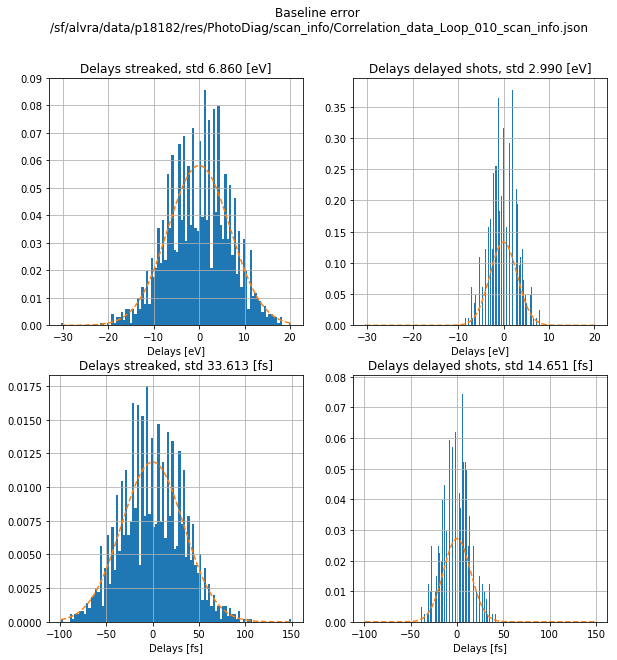

In [7]:
step_num = 1

Streaked_delays = DelaysRAW[step_num,index_pump[step_num,:]]
Streaked_delays -=Streaked_delays.mean()

Unstreaked_delays = DelaysRAW[step_num,index_delayed[step_num,:]]
Unstreaked_delays -=Unstreaked_delays.mean()

plt.figure(figsize=[10,10])
plt.suptitle('Baseline error \n'+ScanFn)
plt.subplot(221)
plt.title('Delays streaked, std %.3f [eV]'%Streaked_delays.std())
n, bins, patches =plt.hist(Streaked_delays,100, density =1);
y = ((1 / (np.sqrt(2 * np.pi) * Streaked_delays.std())) *
     np.exp(-0.5 * (1 / Streaked_delays.std() * (bins))**2))
plt.plot(bins, y, '--')
plt.xlabel('Delays [eV]')
plt.grid()

plt.subplot(222)
plt.title('Delays delayed shots, std %.3f [eV]'%Unstreaked_delays.std())
plt.hist(Unstreaked_delays,100, density =1);
y = ((1 / (np.sqrt(2 * np.pi) * Unstreaked_delays.std())) *
     np.exp(-0.5 * (1 / Unstreaked_delays.std() * (bins))**2))
plt.plot(bins, y, '--')
plt.xlabel('Delays [eV]')
plt.grid()

Streaked_delays = Delays[step_num,index_pump[step_num,:]]
Streaked_delays -=Streaked_delays.mean()

Unstreaked_delays = Delays[step_num,index_delayed[step_num,:]]
Unstreaked_delays -=Unstreaked_delays.mean()

plt.subplot(223)
plt.title('Delays streaked, std %.3f [fs]'%Streaked_delays.std())
n, bins, patches =plt.hist(Streaked_delays,100, density =1);
y = ((1 / (np.sqrt(2 * np.pi) * Streaked_delays.std())) *
     np.exp(-0.5 * (1 / Streaked_delays.std() * (bins))**2))
plt.plot(bins, y, '--')
plt.xlabel('Delays [fs]')
plt.grid()

plt.subplot(224)
plt.title('Delays delayed shots, std %.3f [fs]'%Unstreaked_delays.std())
plt.hist(Unstreaked_delays,100, density =1);
y = ((1 / (np.sqrt(2 * np.pi) * Unstreaked_delays.std())) *
     np.exp(-0.5 * (1 / Unstreaked_delays.std() * (bins))**2))
plt.plot(bins, y, '--')
plt.xlabel('Delays [fs]')
plt.grid()


/sf/photo/miniconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice.
/sf/photo/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/sf/photo/miniconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: Mean of empty slice.


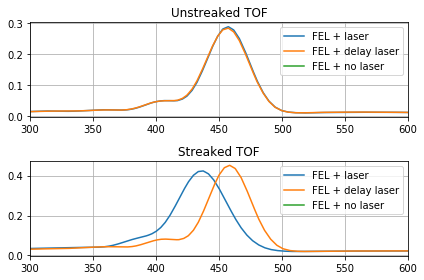

In [8]:
step_num = 1
plt.figure()
plt.subplot(211)
plt.title('Unstreaked TOF')
plt.plot(palm.energy_range,Input_data[step_num]['0'][index_pump[step_num,:],:].mean(axis=0), label= 'FEL + laser' )
plt.plot(palm.energy_range,Input_data[step_num]['0'][index_delayed[step_num,:],:].mean(axis=0),label= 'FEL + delay laser')
plt.plot(palm.energy_range,Input_data[step_num]['0'][index_dark[step_num,:],:].mean(axis=0),label= 'FEL + no laser')
plt.legend()

plt.xlim([300, 600])
plt.grid()
plt.subplot(212)
plt.title('Streaked TOF')
plt.plot(palm.energy_range,Input_data[step_num]['1'][index_pump[step_num,:],:].mean(axis=0), label= 'FEL + laser')
plt.plot(palm.energy_range,Input_data[step_num]['1'][index_delayed[step_num,:],:].mean(axis=0),label= 'FEL + delay laser')
plt.plot(palm.energy_range,Input_data[step_num]['1'][index_dark[step_num,:],:].mean(axis=0),label= 'FEL + no laser')
plt.legend()
plt.xlim([300, 600])
plt.grid()
plt.tight_layout()